# Loading and analysing the YCB grasp data set 

Hyper-paramters and packages 

In [199]:
# Hyper-parameters 
nb_samples = 4500000
# nb_samples = 1500000
nb_classes = 16
# nb_classes = 24 
rand_seed = 42
one_hot = True
test_train_ratio = 0.2
verbose = 2
seq_len = 5 

In [200]:
# Class list names 
class_names = ["Cracker box", 
               "Sugar Box", 
               "Mustard bottle", 
               "Potted meat can", 
               "Banana", 
               "Strawberry", 
               "Apple", 
               "Lemon", 
               "Peach", 
               "Plum", 
               "Bleach cleanser", 
               "Bowl", 
               "Mug", 
               "Duvel bottle", 
               "Liefman bottle", 
               "Wood bowl"]

In [201]:
import numpy as np
import os 
import tensorflow as tf 
import time 
from sklearn.model_selection import train_test_split

In [202]:
import sys
sys.path.append("../..")
from DexterousManipulation.simulations.utils_sim import rodrigue_formula


In [203]:
# Data set location 
data_set_loc_str = r"C:\Users\phili\Documents\GitHub\DexterousManipulation\generations\DATA_SET_YCB_filtered"

### Functions 

In [204]:
def load_norm_data_buckets(data_set_loc_str, nb_samples, nb_classes): 
    x_min = -0.15
    x_max = 0.15
    y_min = -0.15
    y_max = 0.15 
    z_min = 0.13
    z_max = 0.35
    gripper_min = 0 
    gripper_max = 0.041664
    
    nb_data_per_class = int((nb_samples * 1.5)/nb_classes)
    
    norm_metrics_buckets = np.zeros((nb_classes, nb_data_per_class, 1))
    norm_hand_infos_buckets  = np.zeros((nb_classes, nb_data_per_class, 13))
    bucket_counters = np.zeros(nb_classes, dtype=int)
    
    # Counter for the filtered data samples 
    nb_OK_samples = 0 
    nb_failure_samples = 0 
    
    # Loading the data from all files 
    for filename in os.listdir(data_set_loc_str): 
        file_data = np.load(data_set_loc_str + "/" + filename)
        
        file_metrics = file_data["metric"].astype(np.float64)
        file_hand_info = file_data["hand"].astype(np.float64)
        file_obj_classes = file_data["obj"].astype(np.float64)
        
        if nb_OK_samples == nb_samples: 
            break
        
        for metric_index in range(len(file_metrics)):
            if file_metrics[metric_index, 0] == 1.0 and file_metrics[metric_index,1] > 0.0:
                if nb_OK_samples == nb_samples: 
                    break
                curr_class = int(file_obj_classes[metric_index,0])
                
                # Normalizing data 
                # only taking joint distance 
                norm_metrics_buckets[curr_class, bucket_counters[curr_class]] = (file_metrics[metric_index,1] - gripper_min) / (gripper_max - gripper_min)
                tmp_hand_info = file_hand_info[metric_index]
                tmp_hand_info[0] = (tmp_hand_info[0] - x_min) / (x_max - x_min)
                tmp_hand_info[1] = (tmp_hand_info[1] - y_min) / (y_max - y_min)
                tmp_hand_info[2] = (tmp_hand_info[2] - z_min) / (z_max - z_min)
                
                norm_hand_infos_buckets[curr_class,bucket_counters[curr_class]] = np.array(tmp_hand_info)
                
                # Increasing the appropriate counter 
                bucket_counters[int(file_obj_classes[metric_index, 0])] += 1 
                
                nb_OK_samples += 1 
            else: 
                nb_failure_samples += 1 

        
    
    return norm_metrics_buckets, norm_hand_infos_buckets, bucket_counters, nb_OK_samples, nb_failure_samples

In [205]:
def load_YCB_dataset_grasping(data_set_loc_str, nb_samples, test_train_ratio, rand_seed, verbose, seq_len, nb_classes): 
    if verbose >= 1:
        print("Loading Data.")
    start_time = time.time()
    norm_metrics, norm_hand_infos, bucket_counters, _, _ = load_norm_data_buckets(data_set_loc_str, nb_samples, nb_classes)
    end_time = time.time()
    if verbose >= 1:
        print("Time taken to load data: ", end_time - start_time)
    
    nb_data_per_class = int((nb_samples * 1.5)/nb_classes)
    
    inputs = [] 
    outputs = [] 
    
    # Parsing all buckets 
    for bucket_index in range(nb_classes):
        bucket_offset = 0 
        while (bucket_offset < nb_data_per_class) and (norm_metrics[bucket_index, bucket_offset + 4] != 0.0): 
            
            # Build the sequence 
            tmp_buffer = [] 
            for seq_index in range(seq_len): 
                # Fusing the data 
                tmp_list = [] 
                tmp_list.append(norm_metrics[bucket_index, bucket_offset + seq_index, 0])
                for hand_index in range(13): 
                    tmp_list.append(norm_hand_infos[bucket_index, bucket_offset + seq_index, hand_index])
                tmp_buffer.append(tmp_list.copy())
            
            inputs.append(tmp_buffer.copy())
            outputs.append(tf.one_hot(bucket_index, nb_classes, dtype=np.float64).numpy().tolist())
            bucket_offset += 5 
    
    # Shuffling the data 
    X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=test_train_ratio, random_state=rand_seed)
    
    if verbose >= 1:
        print("Size of Train set: ", len(X_train))
        print("Size of Test set: ", len(X_test))
        
    return X_train, X_test, y_train, y_test

In [206]:
def load_norm_data(data_set_loc_str, nb_samples, one_hot, nb_classes): 
    x_min = -0.15
    x_max = 0.15
    y_min = -0.15
    y_max = 0.15 
    z_min = 0.13
    z_max = 0.35
    gripper_min = 0 
    gripper_max = 0.041664
    
    norm_metrics = []
    norm_hand_infos = []
    object_classes = [] 
   
    # Counter for the filtered data samples 
    nb_OK_samples = 0 
    nb_failure_samples = 0 
    
    # Loading the data from all files 
    for filename in os.listdir(data_set_loc_str): 
        file_data = np.load(data_set_loc_str + "/" + filename)
        
        file_metrics = file_data["metric"].astype(np.float64)
        file_hand_info = file_data["hand"].astype(np.float64)
        file_obj_classes = file_data["obj"].astype(np.float64)
        
        if nb_OK_samples == nb_samples: 
            break
        
        for metric_index in range(len(file_metrics)):
            if file_metrics[metric_index, 0] == 1.0 and file_metrics[metric_index,1] > 0.0:
                if nb_OK_samples == nb_samples: 
                    break
                
                # Normalizing data 
                # only taking joint distance 
                norm_metrics.append((file_metrics[metric_index,1] - gripper_min) / (gripper_max - gripper_min)) 
                tmp_hand_info = file_hand_info[metric_index]
                tmp_hand_info[0] = (tmp_hand_info[0] - x_min) / (x_max - x_min)
                tmp_hand_info[1] = (tmp_hand_info[1] - y_min) / (y_max - y_min)
                tmp_hand_info[2] = (tmp_hand_info[2] - z_min) / (z_max - z_min)
                norm_hand_infos.append(tmp_hand_info)
                if one_hot: 
                    object_classes.append(tf.one_hot(int(file_obj_classes[metric_index, 0]), nb_classes, dtype=np.float64).numpy().tolist()) # only taking object class 
                else:     
                    object_classes.append(file_obj_classes[metric_index, 0]) # only taking object class 

                nb_OK_samples += 1 
            else: 
                nb_failure_samples += 1 

        
    
    return norm_metrics, norm_hand_infos, object_classes, nb_OK_samples, nb_failure_samples

In [207]:
def load_YCB_grasp_dataset(data_set_loc_str, nb_samples, test_train_ratio, rand_seed, verbose, seq_len): 
    if verbose >= 1:
        print("Loading Data.")
    start_time = time.time()
    norm_metrics, norm_hand_infos, object_classes, nb_OK_samples, nb_failure_samples = load_norm_data(data_set_loc_str, nb_samples, True, 24)
    end_time = time.time()
    if verbose >= 1:
        print("Time taken to load data: ", end_time - start_time)
    
    inputs = [] 
    outputs = object_classes
    
    # Fusing the informations 
    for index in range(len(norm_metrics)): 
        tmp_list = [] 
        tmp_list.append(np.float64(norm_metrics[index]))
        for hand_index in range(len(norm_hand_infos[-1])): 
            tmp_list.append(np.float64(norm_hand_infos[index][hand_index]))
        inputs.append(tmp_list.copy())
    # Shuffling the data 
    X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=test_train_ratio, random_state=rand_seed)
    
    if verbose >= 1:
        print("Size of Train set: ", len(X_train))
        print("Size of Test set: ", len(X_test))
        
    return X_train, X_test, y_train, y_test

### Executing some testing codes 

In [310]:
norm_metrics_buckets, norm_hand_infos_buckets, bucket_counters, nb_OK_samples, nb_failure_samples = load_norm_data_buckets(data_set_loc_str, nb_samples, nb_classes)

In [227]:
X_train, X_test, y_train, y_test = load_YCB_dataset_grasping(data_set_loc_str, nb_samples, test_train_ratio, rand_seed, verbose, seq_len, nb_classes)

Loading Data.
Time taken to load data:  36.19977307319641
Size of Train set:  239993
Size of Test set:  59999


In [311]:
print(bucket_counters)

[181516 252969 262503 288274 301189 307231 296969 304382 303779 304439
 236098 283614 288869 292474 294054 301640]


In [229]:
# norm_metrics, norm_hand_infos, object_classes, nb_OK_samples, nb_failure_samples = load_norm_data(data_set_loc_str, nb_samples, one_hot, nb_classes)

In [230]:
# X_train, X_test, y_train, y_test = load_YCB_grasp_dataset(data_set_loc_str, nb_samples, test_train_ratio, rand_seed, verbose, seq_len)

Number of non-zero grasps 

In [312]:
non_zero_metrics_list = [] 
non_zero_hands_list = [] 
for index in range(nb_classes):
    non_zero_metrics_list.append([])
    non_zero_hands_list.append([])

In [313]:
nb_non_zero_per_class = np.zeros(nb_classes)
nb_tot_samp_per_class = np.zeros(nb_classes)
for class_index in range(nb_classes): 
    for metric_index in range(len(norm_metrics_buckets[class_index])): 
        if norm_metrics_buckets[class_index, metric_index] > 0.05:
            nb_non_zero_per_class[class_index] += 1 
            non_zero_metrics_list[class_index].append(norm_metrics_buckets[class_index, metric_index])
            non_zero_hands_list[class_index].append(norm_hand_infos_buckets[class_index, metric_index])
        if norm_metrics_buckets[class_index, metric_index] > 0.0: 
            nb_tot_samp_per_class[class_index] += 1 

In [314]:
print(nb_non_zero_per_class)
print(nb_tot_samp_per_class)

[ 728. 1153. 1395.  811. 1139.  860.  623.  684.  729.  763.  471. 5093.
 3754. 1549. 1506. 2701.]
[181516. 252969. 262503. 288274. 301189. 307231. 296969. 304382. 303779.
 304439. 236098. 283614. 288869. 292474. 294054. 301640.]


In [315]:
print(sum(nb_non_zero_per_class)/sum(nb_tot_samp_per_class)*100)

0.5324222222222222


In [316]:
perc_non_zero_grasps = np.zeros(nb_classes)
for class_index in range(nb_classes): 
    perc_non_zero_grasps[class_index] = nb_non_zero_per_class[class_index] / nb_tot_samp_per_class[class_index]

In [317]:
print(perc_non_zero_grasps)

[0.00401067 0.00455787 0.00531422 0.0028133  0.00378168 0.0027992
 0.00209786 0.00224718 0.00239977 0.00250625 0.00199493 0.01795751
 0.01299551 0.0052962  0.00512151 0.00895438]


In [318]:
print(max(perc_non_zero_grasps))

0.017957505623840853


In [319]:
obj_ind_high_perc = [] 
for class_index in range(nb_classes): 
    if perc_non_zero_grasps[class_index] > 0.004:
        obj_ind_high_perc.append(class_index)

In [294]:
print(obj_ind_high_perc)

[0, 1, 2, 11, 12, 13, 14, 15]


In [295]:
print(nb_non_zero_samples/len(filtered_metrics) * 100)

53.333333333333336


### Fetch isolated position coordinates 

## Isolating non-zero grasps 

In [208]:
def load_non_zero_seq(data_set_loc_str, nb_samples, test_train_ratio, rand_seed, verbose, seq_len, nb_classes, lim):
    if verbose >= 1:
        print("Loading Data.")
    start_time = time.time()
    non_zero_metrics_list, non_zero_hands_list = load_non_zero_grasps(data_set_loc_str, nb_samples, nb_classes, lim)
    end_time = time.time()
    if verbose >= 1:
        print("Time taken to load data: ", end_time - start_time)
        
    inputs = [] 
    outputs = []
    
    # Parsing all buckets 
    for bucket_index in range(nb_classes):
        bucket_offset = 0 
        while (bucket_offset + seq_len - 1  < len(non_zero_metrics_list[bucket_index])):
            # Build the sequence 
            tmp_buffer = [] 
            for seq_index in range(seq_len): 
                # Fusing the data 
                tmp_list = [] 
                tmp_list.append(non_zero_metrics_list[bucket_index][bucket_offset + seq_index])
                for hand_index in range(13): 
                    tmp_list.append(non_zero_hands_list[bucket_index][bucket_offset + seq_index][hand_index])
                tmp_buffer.append(tmp_list.copy())
            
            inputs.append(tmp_buffer.copy())
            outputs.append(tf.one_hot(bucket_index, nb_classes, dtype=np.float64).numpy().tolist())
            bucket_offset += seq_len 
            
        
    # Shuffling the data 
    X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=test_train_ratio, random_state=rand_seed)
    
    if verbose >= 1:
        print("Size of Train set: ", len(X_train))
        print("Size of Test set: ", len(X_test))
        
    return X_train, X_test, y_train, y_test

In [209]:
def load_non_zero_grasps(data_set_loc_str, nb_samples, nb_classes, lim): 
    x_min = -0.15
    x_max = 0.15
    y_min = -0.15
    y_max = 0.15 
    z_min = 0.13
    z_max = 0.35
    gripper_min = 0 
    gripper_max = 0.041664
    
    non_zero_metrics_list = [] 
    non_zero_hands_list = [] 
    for index in range(nb_classes):
        non_zero_metrics_list.append([])
        non_zero_hands_list.append([])
        
    for filename in os.listdir(data_set_loc_str): 
        file_data = np.load(data_set_loc_str + "/" + filename)
        
        file_metrics = file_data["metric"].astype(np.float64)
        file_hand_info = file_data["hand"].astype(np.float64)
        file_obj_classes = file_data["obj"].astype(np.float64)
        
        for metric_index in range(len(file_metrics)):
            if file_metrics[metric_index, 0] == 1.0 and file_metrics[metric_index,1] > lim:
                curr_class = int(file_obj_classes[metric_index,0])
                
                non_zero_metrics_list[curr_class].append((file_metrics[metric_index,1] - gripper_min) / (gripper_max - gripper_min))
                tmp_hand_info = file_hand_info[metric_index]
                tmp_hand_info[0] = (tmp_hand_info[0] - x_min) / (x_max - x_min)
                tmp_hand_info[1] = (tmp_hand_info[1] - y_min) / (y_max - y_min)
                tmp_hand_info[2] = (tmp_hand_info[2] - z_min) / (z_max - z_min)
                
                non_zero_hands_list[curr_class].append(tmp_hand_info)
                
    return non_zero_metrics_list, non_zero_hands_list

In [347]:
non_zero_metrics_list, non_zero_hands_list = load_non_zero_grasps(data_set_loc_str, nb_samples, nb_classes, 0.005)

In [358]:
print(len(non_zero_metrics_list[2]))
print(non_zero_metrics_list[2][1])

1619
0.40265927327290385


In [361]:
nb_non_zero_samples_tot = 0
for class_index in range(nb_classes): 
    nb_non_zero_samples_tot += len(non_zero_metrics_list[class_index])

In [362]:
print(nb_non_zero_samples_tot)

27853


In [360]:
X_train, X_test, y_train, y_test = load_non_zero_seq(data_set_loc_str, nb_samples, test_train_ratio, rand_seed, verbose, seq_len, nb_classes, 0.005)

Loading Data.
Time taken to load data:  39.76129984855652
Size of Train set:  3896
Size of Test set:  975


In [320]:
non_zero_metrics_list = [] 
non_zero_hands_list = [] 
for index in range(nb_classes):
    non_zero_metrics_list.append([])
    non_zero_hands_list.append([])

In [321]:
nb_non_zero_per_class = np.zeros(nb_classes)
nb_tot_samp_per_class = np.zeros(nb_classes)
for class_index in range(nb_classes): 
    for metric_index in range(len(norm_metrics_buckets[class_index])): 
        if norm_metrics_buckets[class_index, metric_index] > 0.05:
            nb_non_zero_per_class[class_index] += 1 
            non_zero_metrics_list[class_index].append(norm_metrics_buckets[class_index, metric_index])
            non_zero_hands_list[class_index].append(norm_hand_infos_buckets[class_index, metric_index])
        if norm_metrics_buckets[class_index, metric_index] > 0.0: 
            nb_tot_samp_per_class[class_index] += 1 

In [323]:
# print(non_zero_metrics_list[0])

## Data plots and graphs 

In [243]:
# Importing packages 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

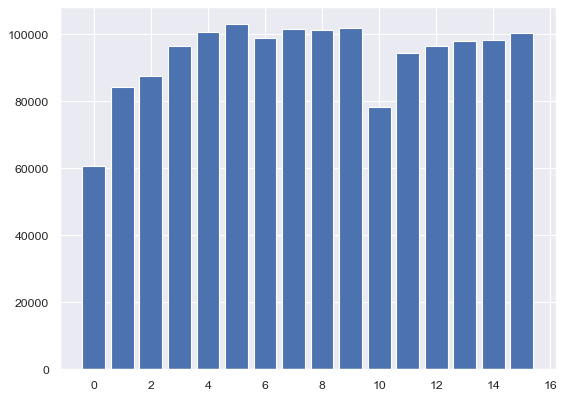

In [244]:
# Histogram: Small vs Big Cube
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(nb_classes), nb_tot_samp_per_class)
plt.show()

## Plots for one of the 16 classes, can be reproduced for each one 

In [1]:
# Creating the directories (ONLY EXECUTE ONCE!)
for index in range(nb_classes): 
    path = r"C:\Users\phili\Documents\GitHub\DexterousManipulation\Figures\Data\YCB_data_set_filtered\class_" + str(index)
    os.mkdir(path)

NameError: name 'nb_classes' is not defined

In [297]:
class_index = 0

In [298]:
class_saving_str = r"C:\Users\phili\Documents\GitHub\DexterousManipulation\Figures\Data\YCB_data_set_filtered\class_" + str(class_index)

num_bins = 100 # for histogram 


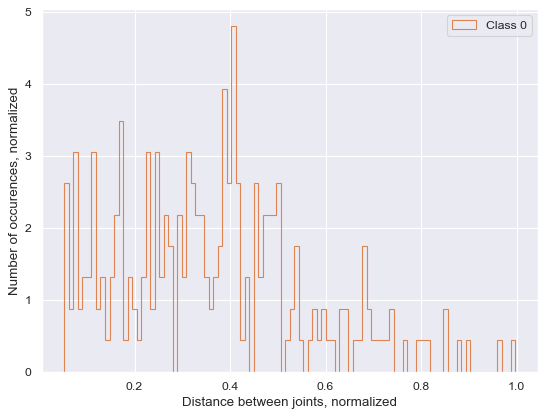

In [299]:
# Histogram: Small vs Big Cube
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(np.asarray(non_zero_metrics_list[class_index]), bins=num_bins, density=True, histtype='step', color="C1", stacked=True)
plt.xlabel("Distance between joints, normalized")
plt.ylabel("Number of occurences, normalized")
# plt.title("Comparing class distributions")
#create legend
# handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["C1", "C2"]]
labels= ["Class " + str(class_index)]
plt.legend(labels)
plt.savefig(class_saving_str + "/histogram_joint_dist.png")
plt.show()

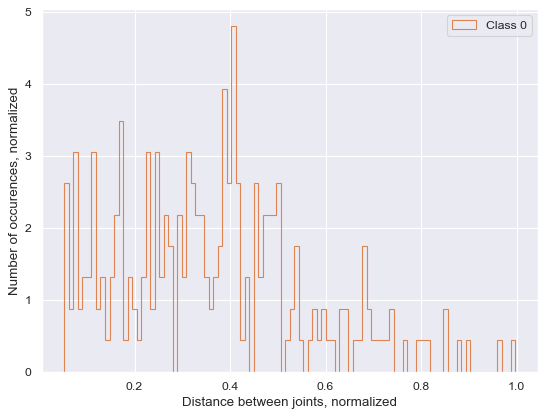

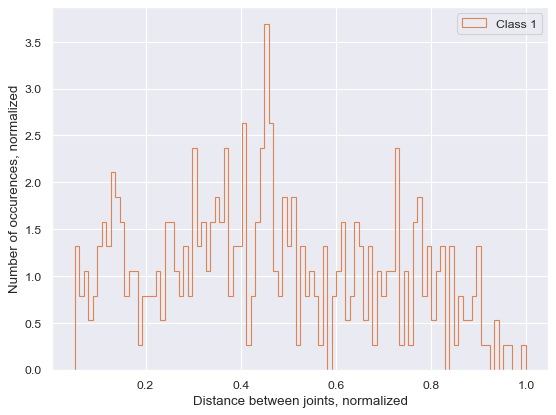

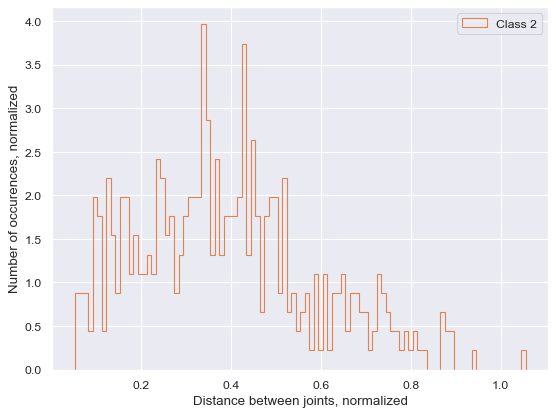

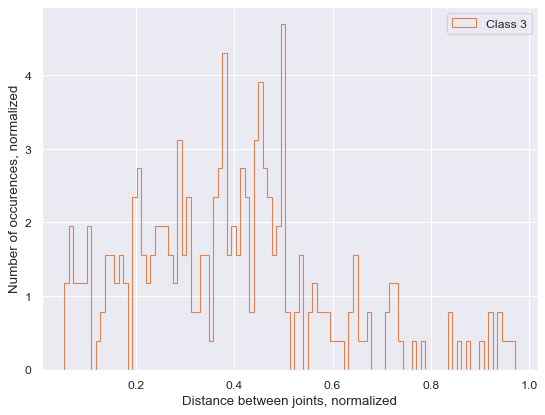

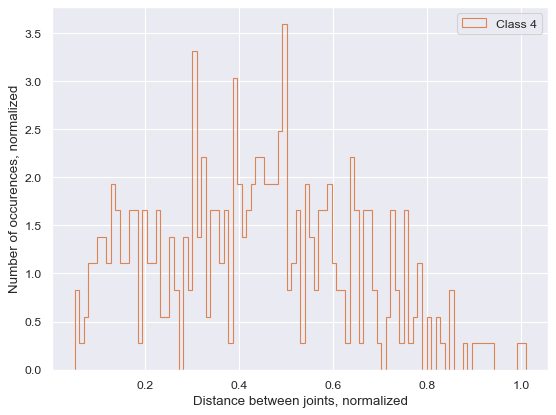

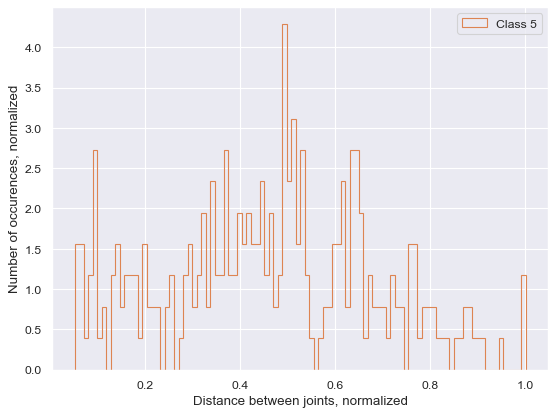

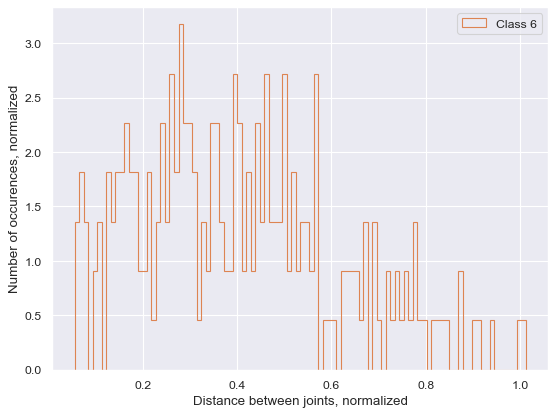

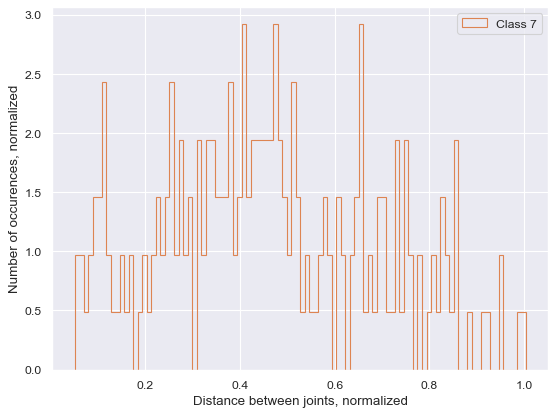

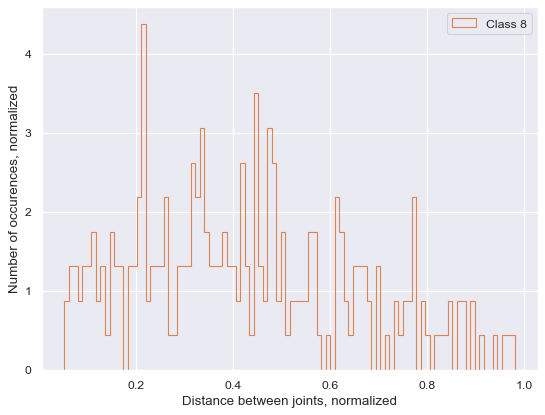

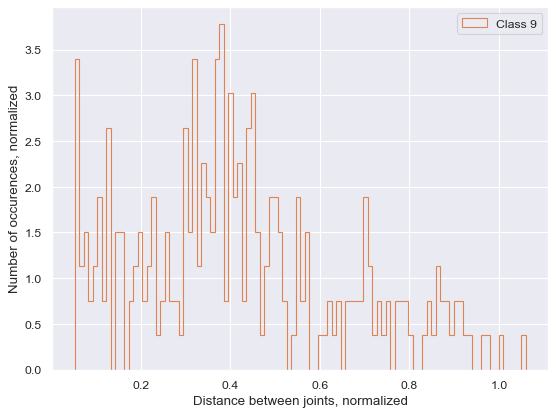

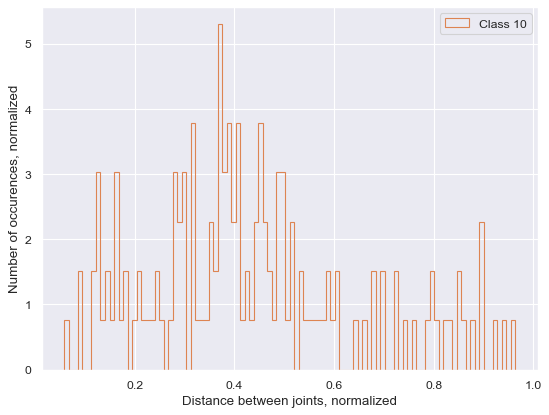

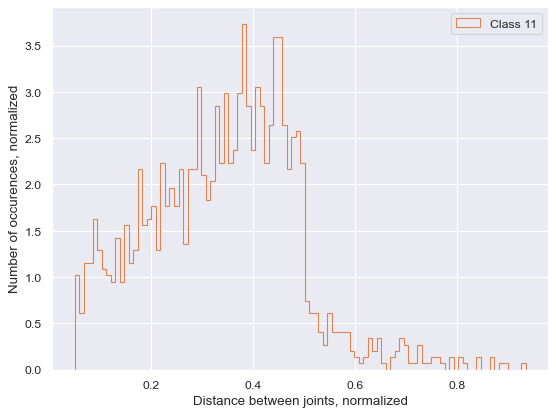

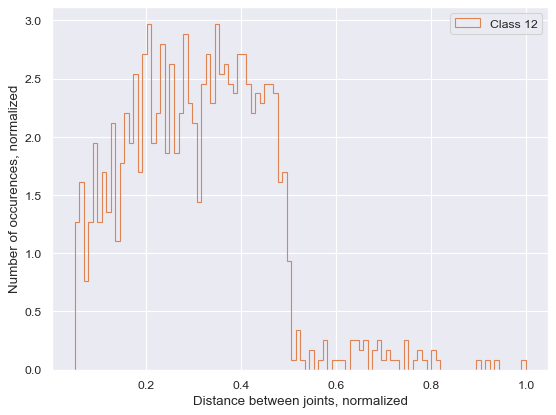

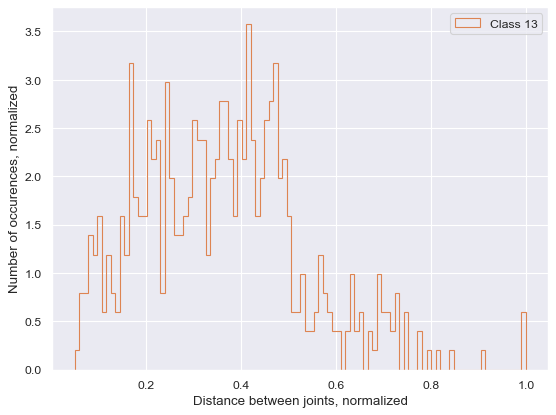

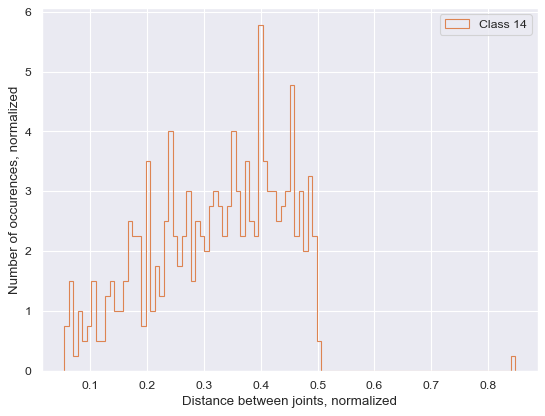

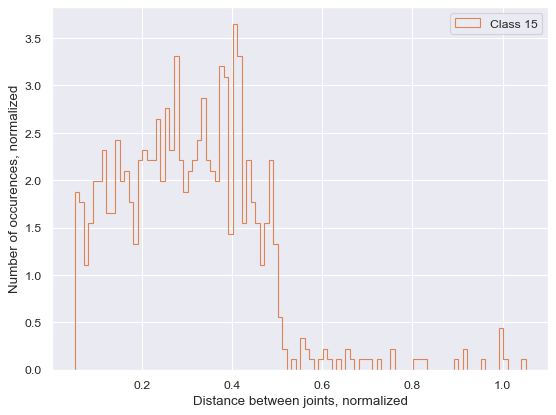

In [300]:
for class_index in range(nb_classes): 
    class_saving_str = r"C:\Users\phili\Documents\GitHub\DexterousManipulation\Figures\Data\YCB_data_set_filtered\class_" + str(class_index)

    num_bins = 100 # for histogram 
    
    # Histogram: Small vs Big Cube
    plt.figure(figsize=(8, 6), dpi=80)
    plt.hist(np.asarray(non_zero_metrics_list[class_index]), bins=num_bins, density=True, histtype='step', color="C1", stacked=True)
    plt.xlabel("Distance between joints, normalized")
    plt.ylabel("Number of occurences, normalized")
    # plt.title("Comparing class distributions")
    #create legend
    # handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ["C1", "C2"]]
    labels= ["Class " + str(class_index)]
    plt.legend(labels)
    plt.savefig(class_saving_str + "/histogram_joint_dist.png")
    plt.show()


Class: 0: Cracker box


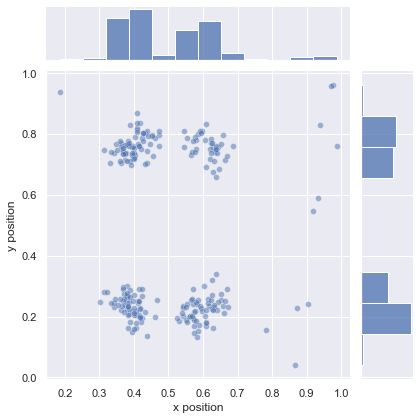

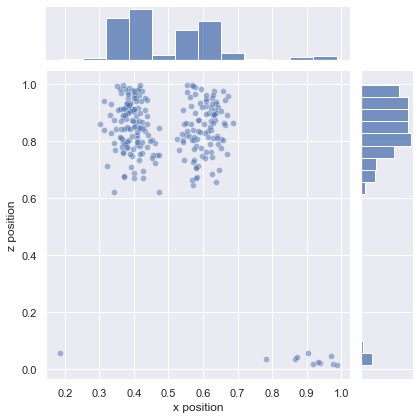

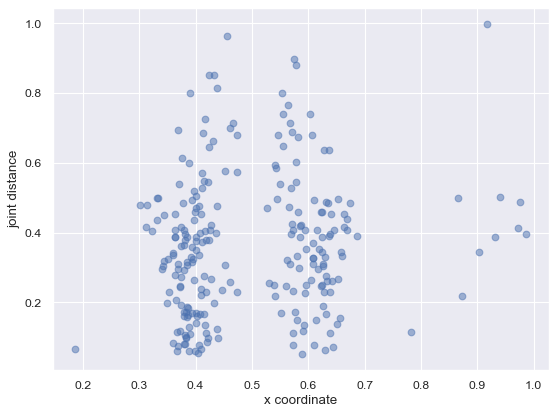

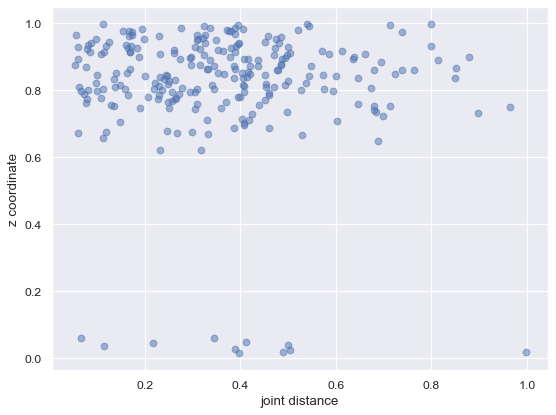

Class: 1: Sugar Box


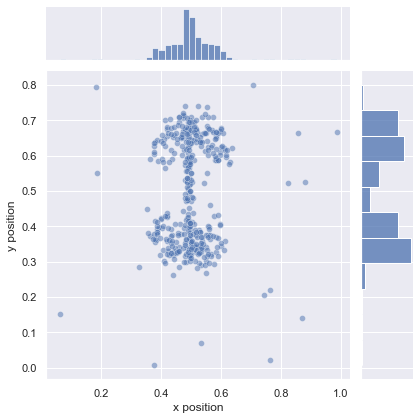

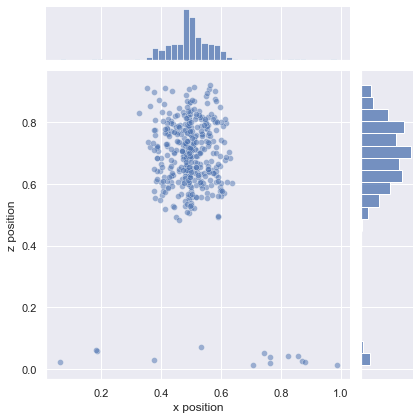

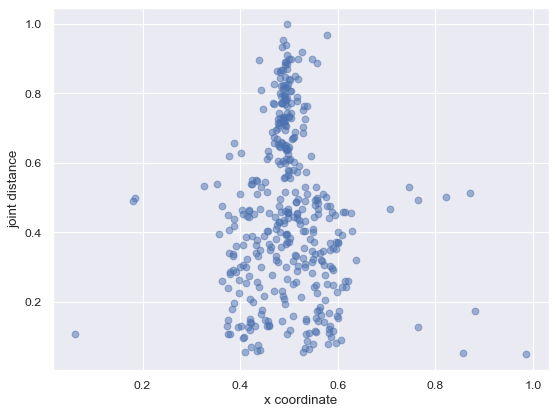

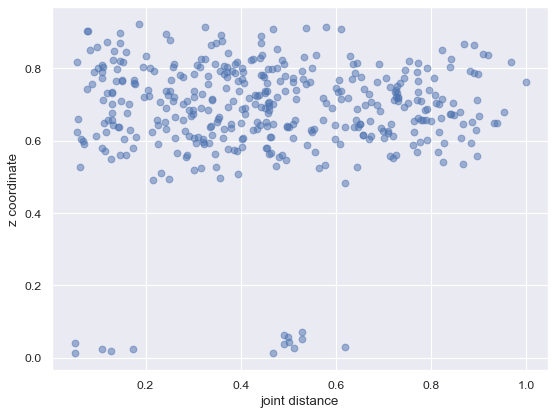

Class: 2: Mustard bottle


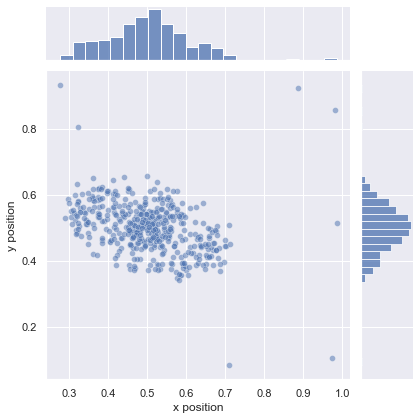

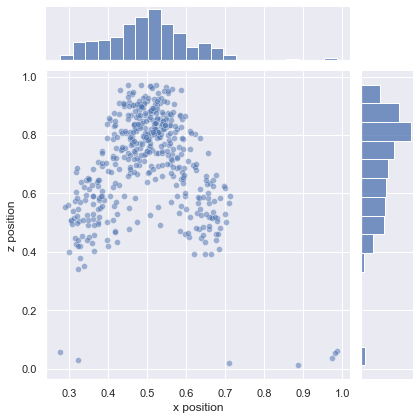

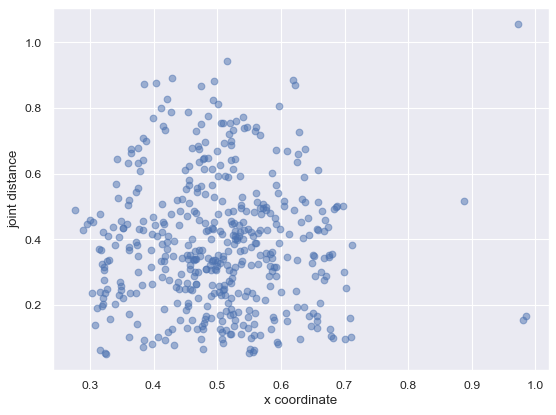

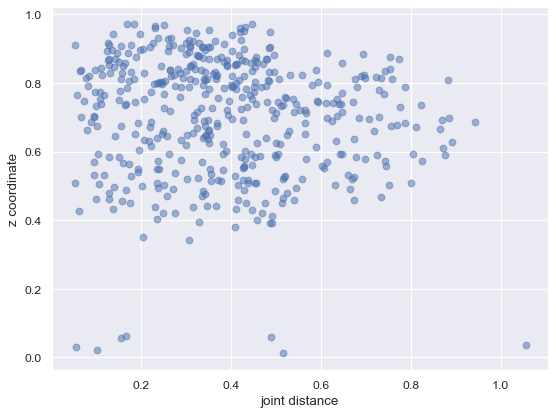

Class: 3: Potted meat can


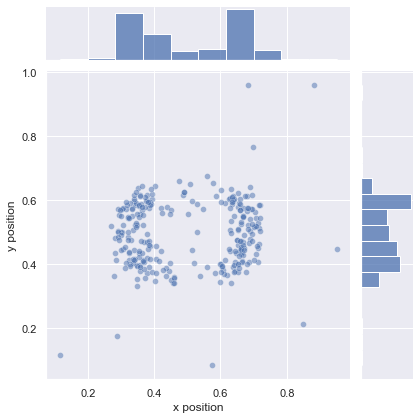

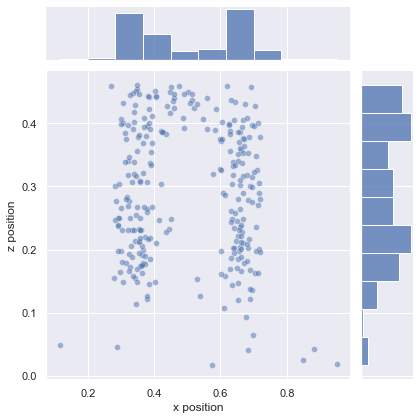

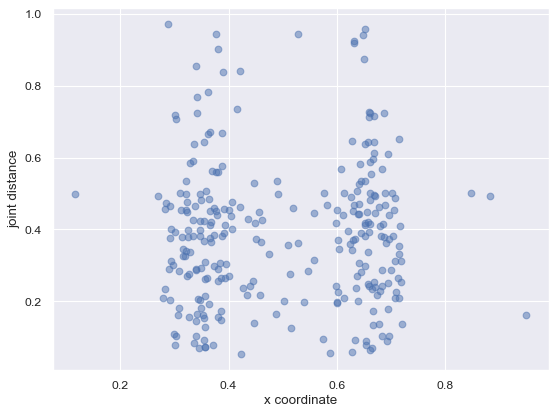

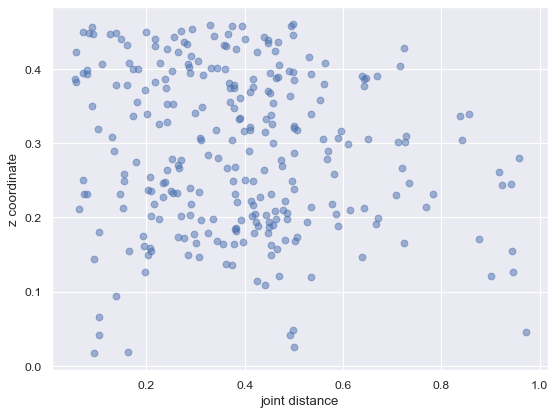

Class: 4: Banana


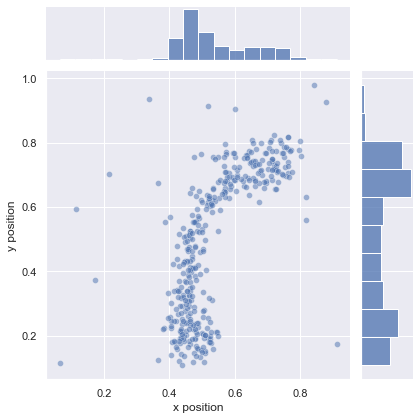

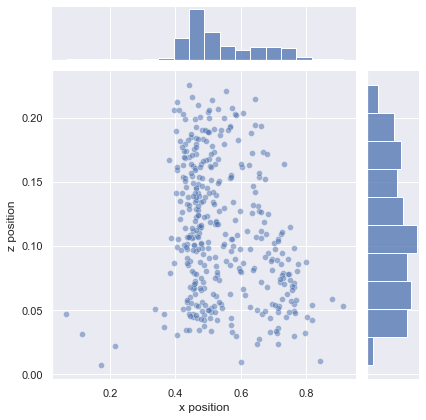

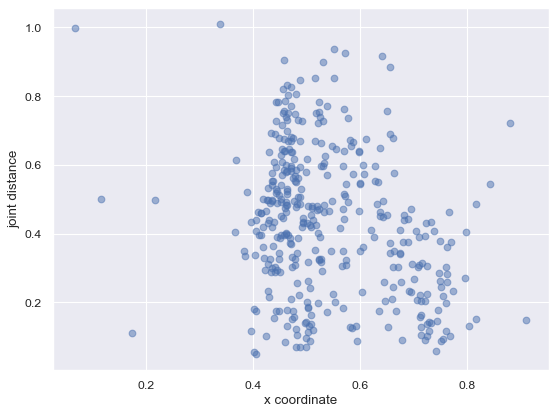

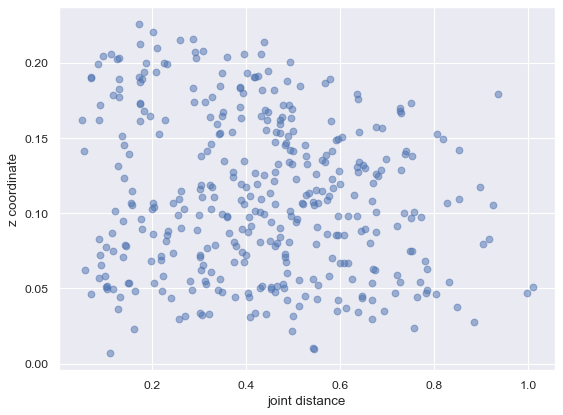

Class: 5: Strawberry


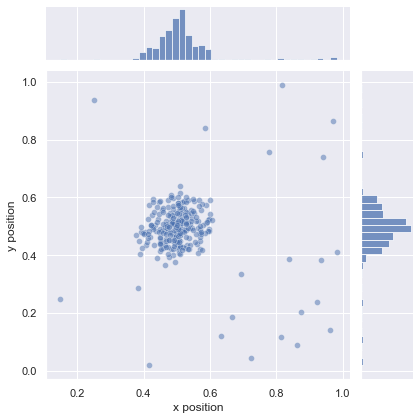

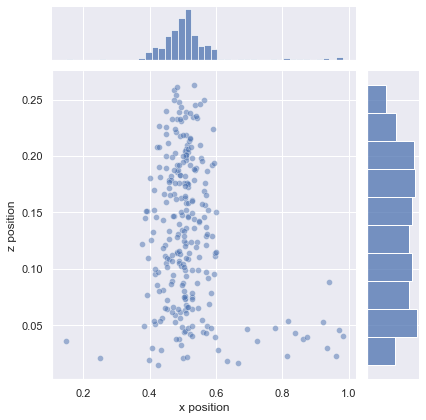

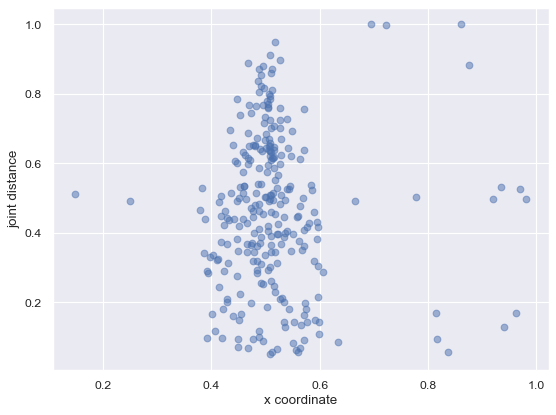

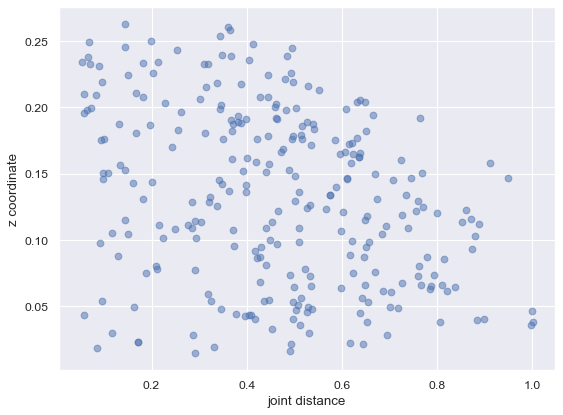

Class: 6: Apple


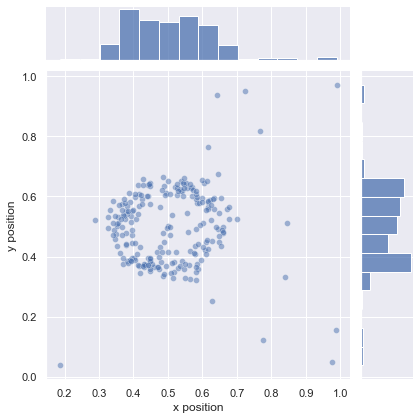

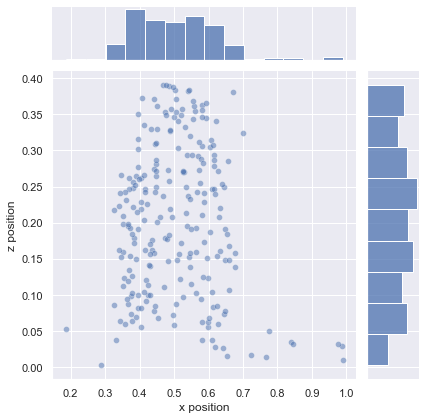

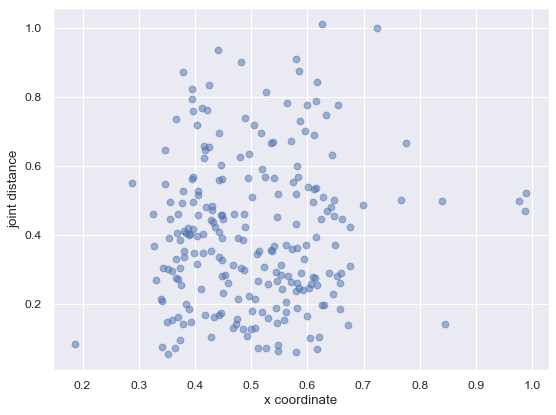

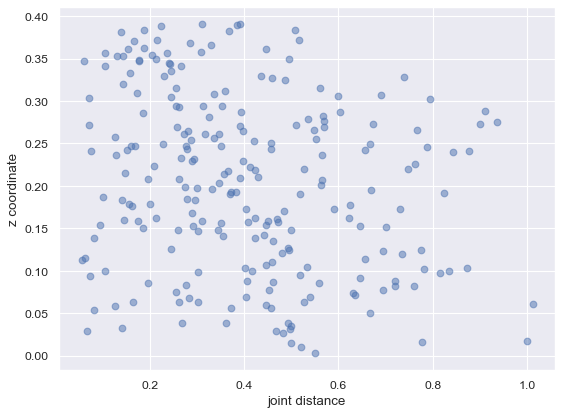

Class: 7: Lemon


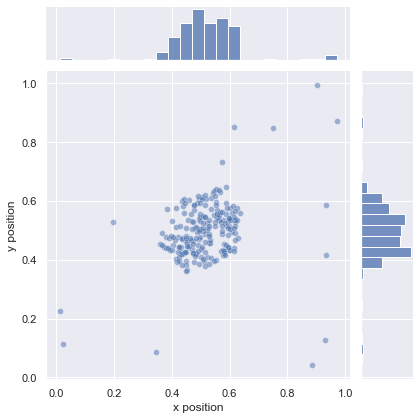

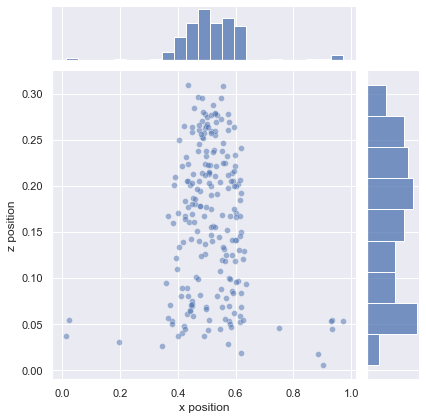

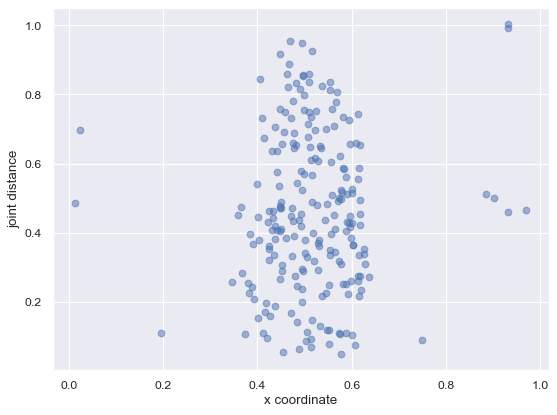

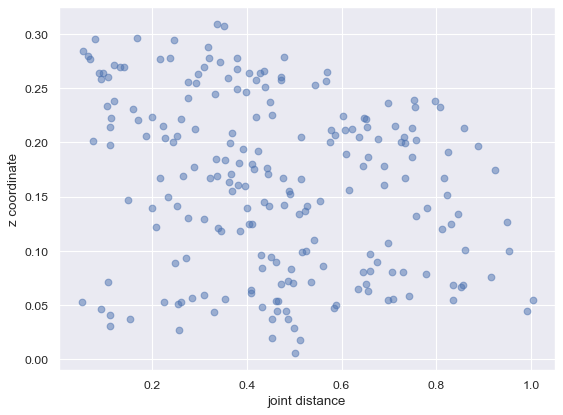

Class: 8: Peach


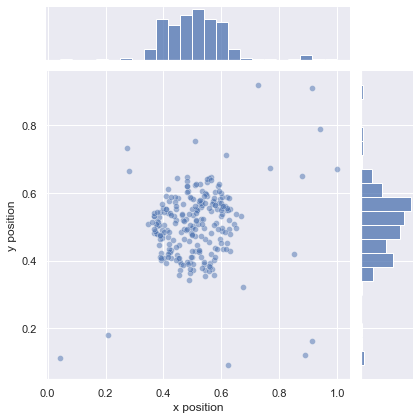

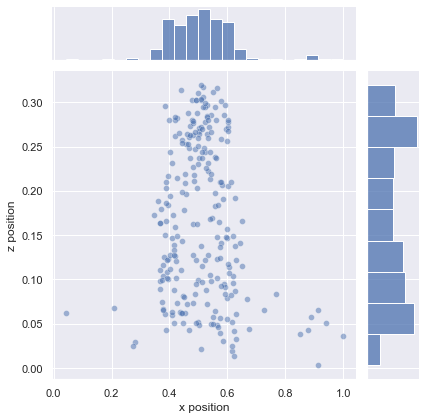

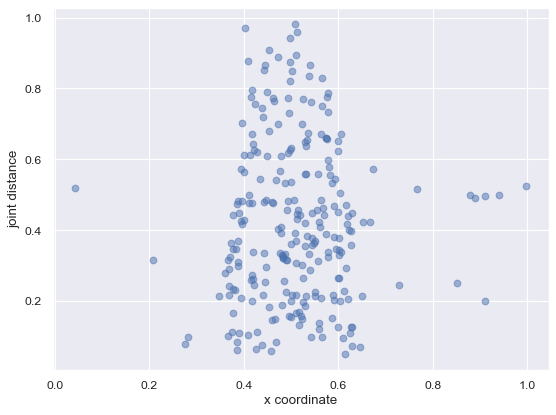

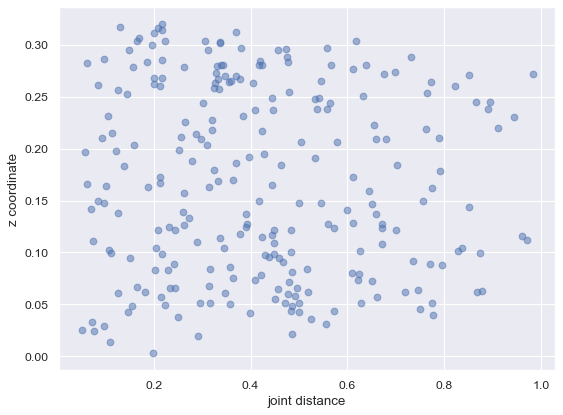

Class: 9: Plum


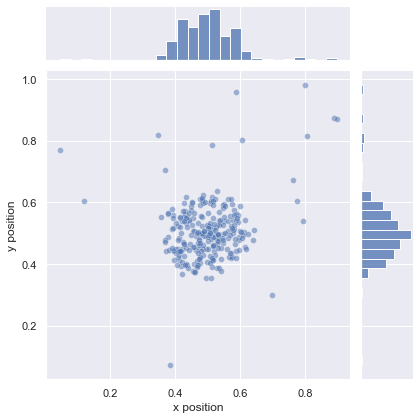

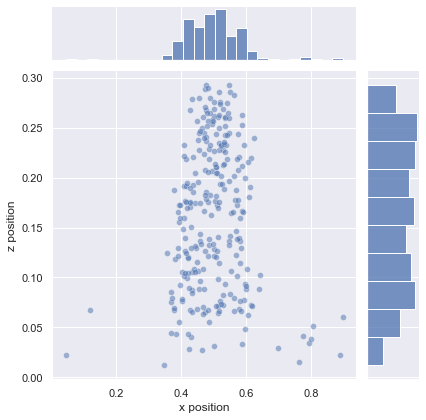

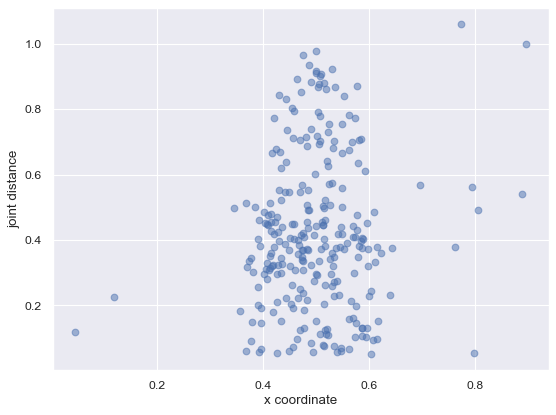

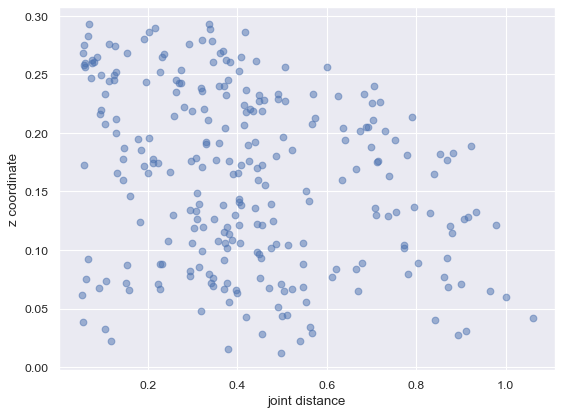

Class: 10: Bleach cleanser


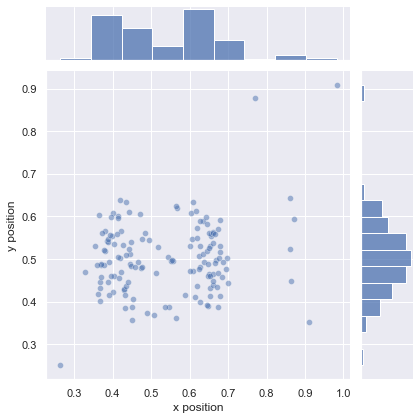

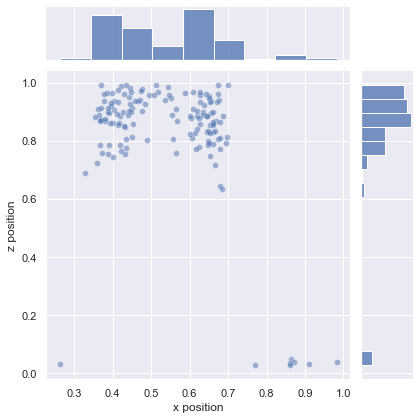

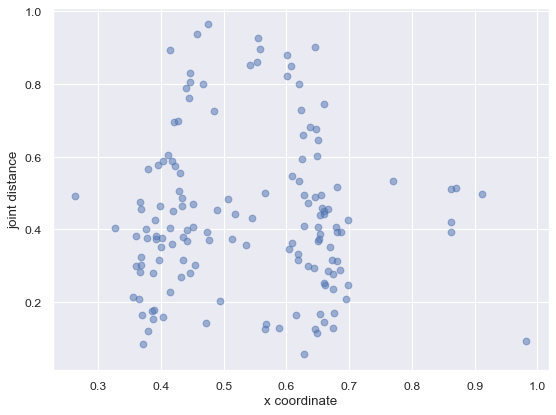

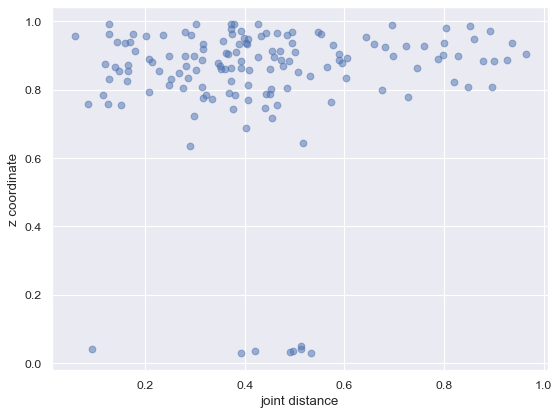

Class: 11: Bowl


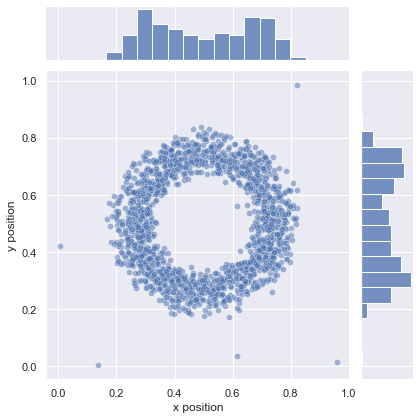

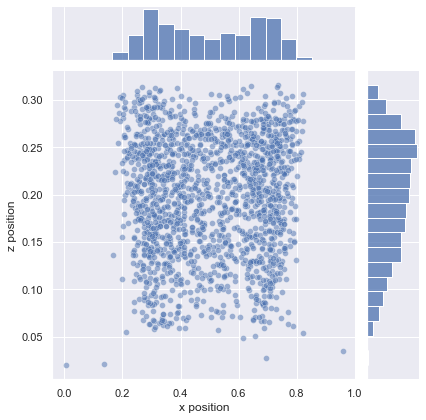

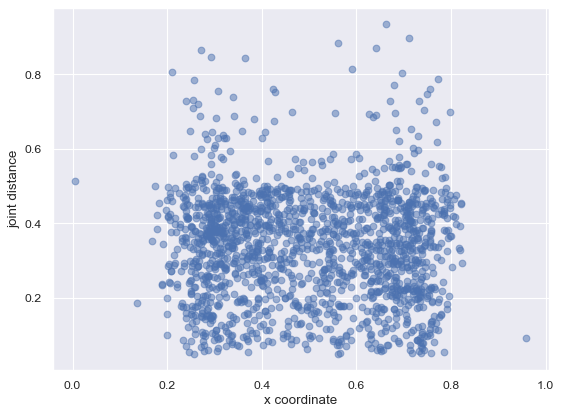

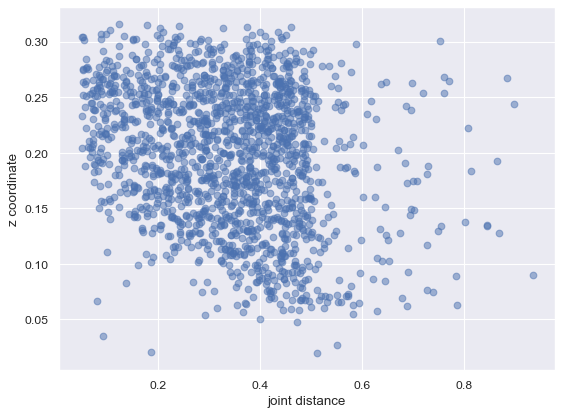

Class: 12: Mug


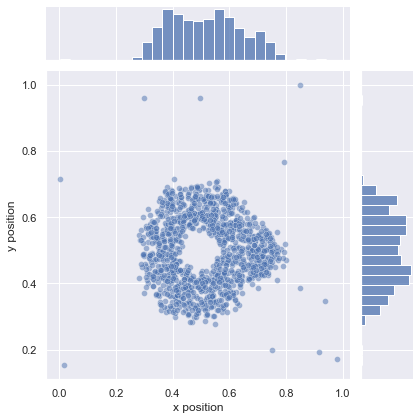

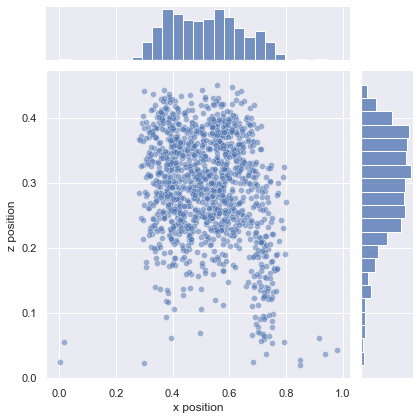

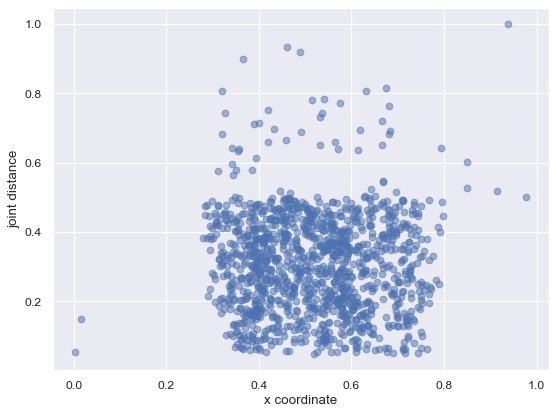

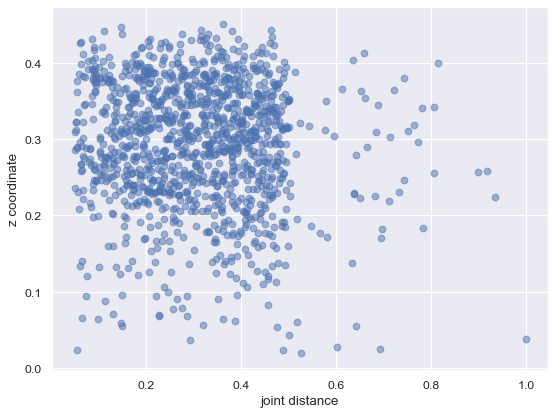

Class: 13: Duvel bottle


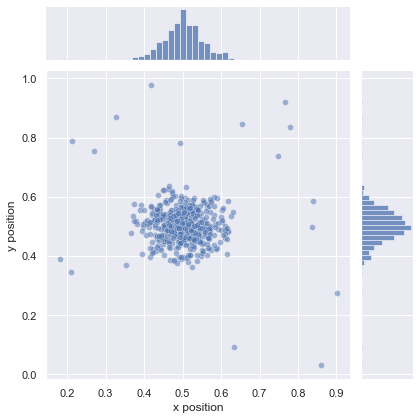

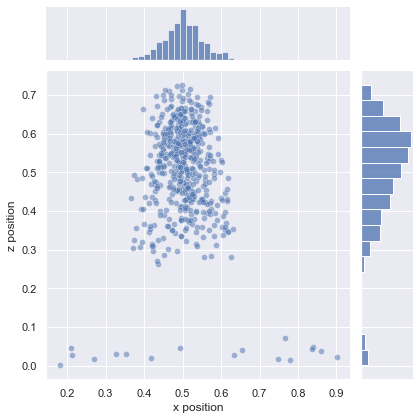

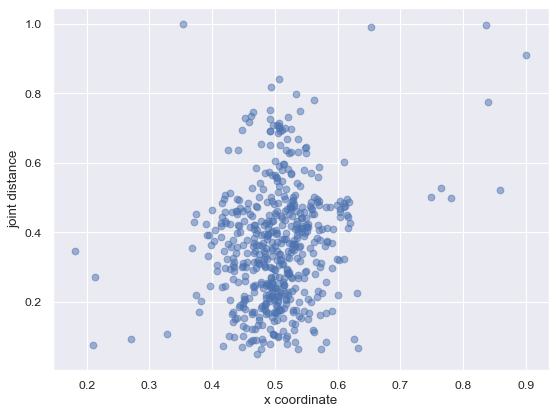

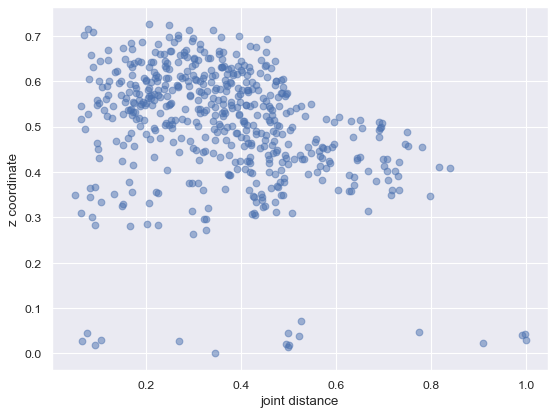

Class: 14: Liefman bottle


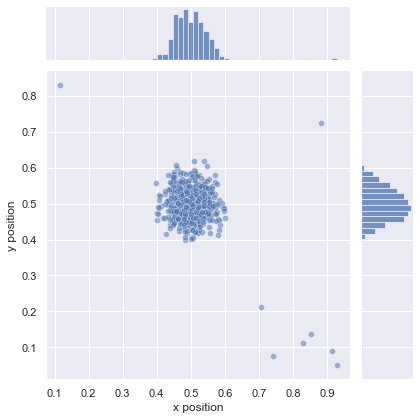

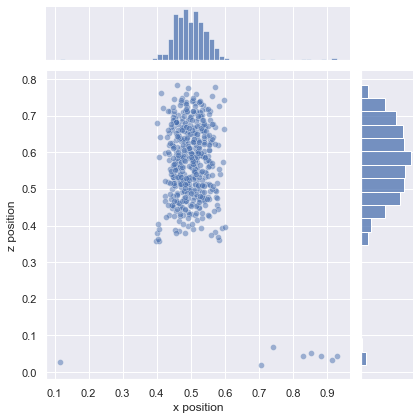

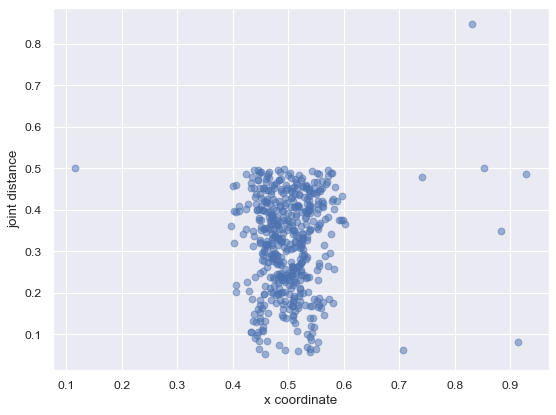

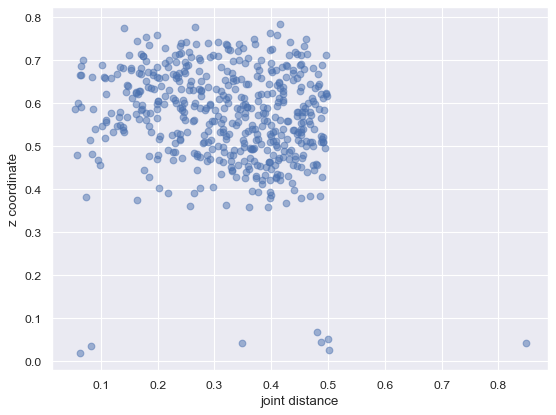

Class: 15: Wood bowl


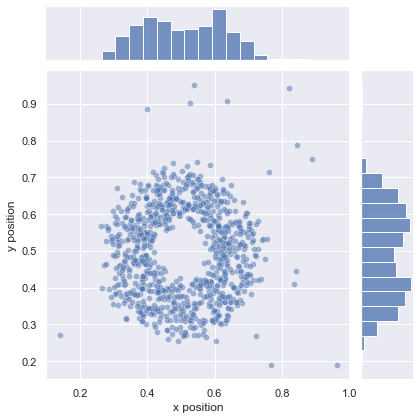

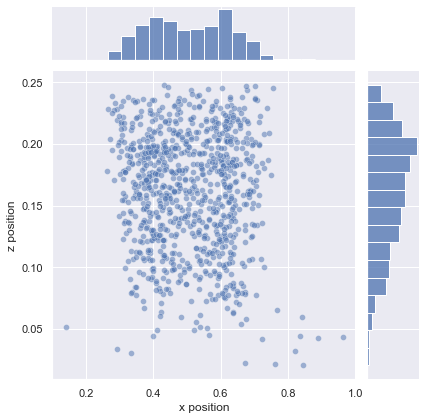

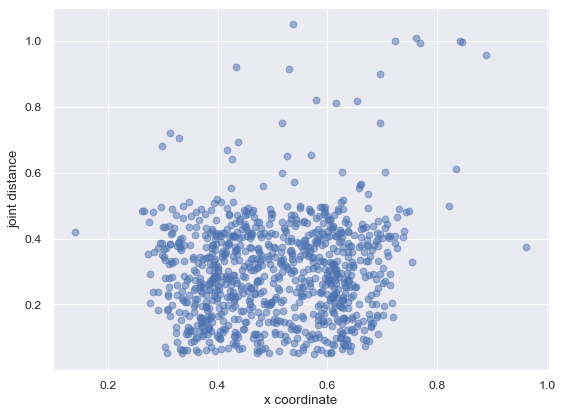

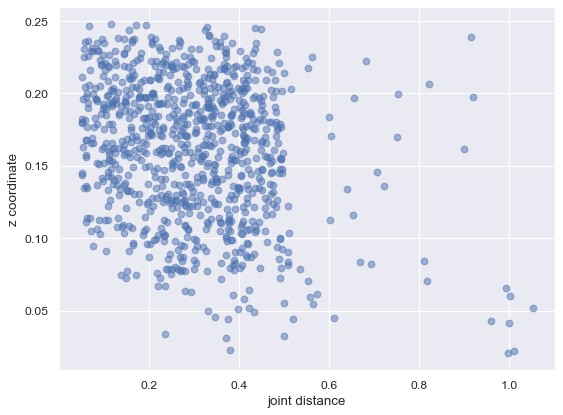

In [301]:
for class_index in range(nb_classes): 
    class_saving_str = r"C:\Users\phili\Documents\GitHub\DexterousManipulation\Figures\Data\YCB_data_set_filtered\class_" + str(class_index)
    
    curr_class_str = "Class: " + str(class_index) + ": " + class_names[class_index]
    print(curr_class_str)
    non_zero_x = [] 
    non_zero_y = []
    non_zero_z = [] 
    non_zero_dist = []
    
    tmp_hand = non_zero_hands_list[class_index]
    tmp_dist = non_zero_metrics_list[class_index]
    for hand_index in range(len(tmp_hand)):
        
        tmp_hand_bis = tmp_hand[hand_index]
        tmp_dist_bis = tmp_dist[hand_index]
        non_zero_x.append(tmp_hand_bis[0])
        non_zero_y.append(tmp_hand_bis[1])
        non_zero_z.append(tmp_hand_bis[2])
        non_zero_dist.append(tmp_dist_bis)
        
     
    
    df = pd.DataFrame({"x position": non_zero_x, "y position": non_zero_y})
    h = sns.jointplot(data=df, x="x position", y="y position", alpha = 0.5)
    h.savefig(class_saving_str + "/Jointplot_XY_normalized.png")
    plt.show()
    
    df = pd.DataFrame({"x position": non_zero_x, "z position": non_zero_z})
    h = sns.jointplot(data=df, x="x position", y="z position", alpha = 0.5)
    h.savefig(class_saving_str + "/Jointplot_XZ_normalized.png")
    plt.show()
    
    plt.figure(figsize=(8, 6), dpi=80)
    plt.scatter(non_zero_x, non_zero_dist,  alpha = 0.5)
    plt.xlabel("x coordinate")
    plt.ylabel("joint distance")
    plt.title("")
    plt.savefig(class_saving_str + "/Jointplot_TX_normalized.png")
    plt.show()
    
    plt.figure(figsize=(8, 6), dpi=80)
    plt.scatter(non_zero_dist, non_zero_z,  alpha = 0.5)
    plt.xlabel("joint distance")
    plt.ylabel("z coordinate")
    plt.title("")
    plt.savefig(class_saving_str + "/Jointplot_TZ_NON_ZERO_normalized.png")
    plt.show()

### Loading, filtering and saving the (old) data set 

In [139]:
# Data set location 
old_data_set_loc_str = r"C:\Users\phili\Documents\GitHub\DexterousManipulation\generations\DATA_SET_YCB_filtered"
nb_classes = 16

In [140]:
non_zero_metrics_list, non_zero_hands_list = load_non_zero_grasps(old_data_set_loc_str, nb_samples, nb_classes, 0.005)

Taking only the classes needed (skip this for the already filtered data set) 

In [72]:
new_class_list_indexes = [1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 20, 21, 23]

In [73]:
nb_classes = 16 
non_zero_metrics_list_classes = []
non_zero_hands_list_classes = [] 

In [74]:
for class_index in range(nb_classes): 
    curr_ind = new_class_list_indexes[class_index]
    non_zero_metrics_list_classes.append(non_zero_metrics_list[curr_ind])
    non_zero_hands_list_classes.append(non_zero_hands_list[curr_ind])

In [75]:
print(len(non_zero_metrics_list_classes))

16


In [141]:
nb_classes = 16 

In [142]:
counters = [] 
for class_index in range(nb_classes): 
    counters.append(len(non_zero_metrics_list[class_index]))

In [143]:
print(counters)

[1442, 2317, 2974, 1650, 2394, 1877, 1268, 1428, 1451, 1593, 1023, 10384, 7340, 3192, 3183, 5276]


In [144]:
print(sum(counters))

48792


In [145]:
non_zero_metrics_list_arr = [] 
for class_index in range(nb_classes): 
    non_zero_metrics_list_arr.append(np.asarray(non_zero_metrics_list[class_index]))

Transforming the hands rotation matrix into a simple angle and dropping the preshape 

In [158]:

def transform_hand_format(x): 
    # Position variables
    pos = x[..., 0:3]
    
    # Preshape
    preshape = x[..., 12:]

    # Rotation matrices
    rot_mat = x[..., 3:12]
    axis = rot_mat[:, 0:9:3]
    ry = rot_mat[:, 1:9:3]
    rz = rot_mat[:, 2:9:3]

    # Base frame
    x_axis = tf.tile(tf.constant([[1., 0., 0.]]), [pos.shape[0], 1])
    y_axis = tf.tile(tf.constant([[0., 1., 0.]]), [pos.shape[0], 1])

    # Align with the wanted x axis
    cross_axis = tf.linalg.normalize(tf.linalg.cross(axis, x_axis), axis=-1)[0]
    cross_axis = tf.where(tf.math.is_nan(cross_axis), tf.constant([0., 1., 0.]), cross_axis)
    dot_product = tf.reduce_sum(tf.multiply(axis, x_axis), axis=-1, keepdims=True)
    int_angle = tf.acos(dot_product)
    ry_int_axis = tf.linalg.normalize(rodrigue_formula(ry, cross_axis, int_angle), axis=-1)[0]

    # Compute the angle
    dot_product = tf.reduce_sum(tf.multiply(y_axis, ry_int_axis), axis=-1, keepdims=True)
    y_angle = tf.acos(dot_product)
    angle = tf.reshape(tf.math.sign(ry_int_axis)[:, -1:]*y_angle, [-1])

   
    return [pos, axis, angle, preshape]

In [159]:
non_zero_hands_pos_list_preprocessed = [] 
non_zero_hands_angles_list_preprocessed = [] 
for class_index in range(nb_classes): 
    # tmp_list = transform_hand_format(np.asarray(non_zero_hands_list_classes[class_index])) 
    tmp_list = transform_hand_format(np.asarray(non_zero_hands_list[class_index]))
    # Skipping the preshape intentionally 
    non_zero_hands_pos_list_preprocessed.append(tmp_list[0])
    non_zero_hands_angles_list_preprocessed.append(tmp_list[2])
        

In [191]:
non_zero_hands_pos_list_preprocessed[0]

array([[0.66967644, 0.23330771, 0.69727299],
       [0.40867662, 0.194962  , 0.82520109],
       [0.36749291, 0.29283045, 0.89674807],
       ...,
       [0.40857231, 0.76113749, 0.8805184 ],
       [0.44753038, 0.21001255, 0.82231108],
       [0.33038485, 0.7436991 , 0.81810637]])

Saving the preprocessed data in an npz file for further use 

In [160]:
# saving_str = r"C:\Users\phili\Documents\GitHub\DexterousManipulation\generations\intermediate_Data_YCB\old_data_set_6_mil"
saving_str = r"C:\Users\phili\Documents\GitHub\DexterousManipulation\generations\intermediate_Data_YCB\new_data_set_12_mil"
for class_index in range(nb_classes): 
    complete_saving_str = saving_str + "/preprocessed_data_class_" + str(class_index) + ".npz"
    np.savez_compressed(complete_saving_str, 
                        metrics = non_zero_metrics_list_arr[class_index], 
                        hand_pos = non_zero_hands_pos_list_preprocessed[class_index], 
                        hand_angles = non_zero_hands_angles_list_preprocessed[class_index]) 

# Preparing the final, balanced data set 

In [180]:
nb_max_samples_per_class = 10000

In [181]:
# Loading the data 
loading_str_6 = r"C:\Users\phili\Documents\GitHub\DexterousManipulation\generations\intermediate_Data_YCB\old_data_set_6_mil"
loading_str_12 = r"C:\Users\phili\Documents\GitHub\DexterousManipulation\generations\intermediate_Data_YCB\new_data_set_12_mil"
nb_classes = 16 
seq_len = 5 

In [182]:
def load_non_zero_from_npz(file_location): 
    file_data = np.load(file_location)
    file_metrics = file_data["metrics"].astype(np.float64)
    file_hand_pos = file_data["hand_pos"].astype(np.float64)
    file_hand_angles = file_data["hand_angles"].astype(np.float64)
    
    inputs_list = []
    for index in range(len(file_metrics)):
        tmp_list = [] 
        tmp_list.append(file_metrics[index])
        tmp_list.append(file_hand_pos[index,0])
        tmp_list.append(file_hand_pos[index,1])
        tmp_list.append(file_hand_pos[index,2])
        tmp_list.append(file_hand_angles[index])
        inputs_list.append(tmp_list.copy())
        
    return inputs_list

In [184]:
inputs = []
outputs = [] 

In [186]:
# Complete loop for old 
for class_index in range(nb_classes): 
    tmp_str = loading_str_6 + "/preprocessed_data_class_" + str(class_index) + ".npz"
    tmp_input_list = load_non_zero_from_npz(tmp_str)
        
    bucket_offset = 0 
    while (bucket_offset + seq_len - 1  < len(tmp_input_list)):
        # Build the sequence 
        tmp_buffer = [] 
        for seq_index in range(seq_len): 
            tmp_buffer.append(tmp_input_list[bucket_offset + seq_index])

        inputs.append(tmp_buffer.copy())
        outputs.append(tf.one_hot(class_index, nb_classes, dtype=np.float64).numpy().tolist())
        bucket_offset += seq_len 

In [188]:
# Complete loop for new 
for class_index in range(nb_classes): 
    tmp_str = loading_str_12 + "/preprocessed_data_class_" + str(class_index) + ".npz"
    tmp_input_list = load_non_zero_from_npz(tmp_str)
   
    bucket_offset = 0 
    while (bucket_offset + seq_len - 1  < len(tmp_input_list)):
        # Build the sequence 
        tmp_buffer = [] 
        for seq_index in range(seq_len): 
            tmp_buffer.append(tmp_input_list[bucket_offset + seq_index])

        inputs.append(tmp_buffer.copy())
        outputs.append(tf.one_hot(class_index, nb_classes, dtype=np.float64).numpy().tolist())
        bucket_offset += seq_len 

In [189]:
print(len(inputs))
print(len(outputs))

12983
12983


Making the sequences! 

In [176]:
# Shuffling the data 
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=test_train_ratio, random_state=rand_seed)

In [177]:
print("Size of Train set: ", len(X_train))
print("Size of Test set: ", len(X_test))

Size of Train set:  51992
Size of Test set:  12998


In [198]:
print(X_train[0])

[0.520023844918714, 0.44708408912022907, 0.6485949754714966, 0.6930814331228083, 1.179070234298706]
